##Loading data





In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('dataset.csv')

# Drop first column 'id' and 'Flight' column
df.drop(columns=[df.columns[0], 'flight'], inplace=True)

print("Column names:", df.columns.tolist())

Column names: ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']


#Preprocessing

In [2]:
# one hot encoding for categrogrical columns
label_cols = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

df = pd.get_dummies(df, columns=label_cols)




In [3]:
print("Column names:", df.columns.tolist())
print(df.iloc[0])

Column names: ['duration', 'days_left', 'price', 'airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara', 'source_city_Bangalore', 'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai', 'departure_time_Afternoon', 'departure_time_Early_Morning', 'departure_time_Evening', 'departure_time_Late_Night', 'departure_time_Morning', 'departure_time_Night', 'stops_one', 'stops_two_or_more', 'stops_zero', 'arrival_time_Afternoon', 'arrival_time_Early_Morning', 'arrival_time_Evening', 'arrival_time_Late_Night', 'arrival_time_Morning', 'arrival_time_Night', 'destination_city_Bangalore', 'destination_city_Chennai', 'destination_city_Delhi', 'destination_city_Hyderabad', 'destination_city_Kolkata', 'destination_city_Mumbai', 'class_Business', 'class_Economy']
duration                         2.17
days_left                           1
price                            5953
airline_Air

## defining targets and features

In [3]:
X = df.drop('price', axis=1)  # Features
y = df['price']               # Target

In [4]:
print(y.iloc[0])

5953


## Splitting data into train, validation and test

In [5]:
from sklearn.model_selection import train_test_split

# Step 1: Split into train+val and test (80% train+val, 20% test)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split train+val into train and validation (e.g., 75% train, 25% val of 80%)
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=42)
# 0.25 x 0.8 = 0.2, so final ratio: 60% train, 20% val, 20% test


##Features scaling

In [6]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler, StandardScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit only on training data (make sure to pass a DataFrame, not a Series)
scaler.fit(X_train[['duration', 'days_left']])

# Transform both train and test sets
X_train[['duration', 'days_left']] = scaler.transform(X_train[['duration', 'days_left']])
X_val[['duration', 'days_left']] = scaler.transform(X_val[['duration', 'days_left']])
X_test[['duration', 'days_left']] = scaler.transform(X_test[['duration', 'days_left']])

# Print min and max after scaling
print(X_train['duration'].min(), X_train['duration'].max())
print(X_train['days_left'].min(), X_train['days_left'].max())
print(X_val['duration'].min(), X_val['duration'].max())
print(X_val['days_left'].min(), X_val['days_left'].max())
print(X_test['duration'].min(), X_test['duration'].max())
print(X_test['days_left'].min(), X_test['days_left'].max())


0.0 0.9999999999999999
0.0 0.9999999999999999
0.0 0.9999999999999999
0.0 0.9999999999999999
0.0 0.9575510204081632
0.0 0.9999999999999999


# Applying PySpark

## creat spark dataframe

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder.appName("FlightPricePrediction").getOrCreate()

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

spark_train_df = spark.createDataFrame(train_df)
spark_val_df = spark.createDataFrame(val_df)
spark_test_df = spark.createDataFrame(test_df)

spark_train_df.show(5)
spark_val_df.show(5)
spark_test_df.show(5)

feature_columns = X_train.columns.tolist() # get all features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(spark_train_df).select("features", "price")
val_data = assembler.transform(spark_val_df).select("features", "price")
test_data = assembler.transform(spark_test_df).select("features", "price")


+-------------------+------------------+---------------+-----------------+----------------+--------------+----------------+---------------+---------------------+-------------------+-----------------+---------------------+-------------------+------------------+------------------------+----------------------------+----------------------+-------------------------+----------------------+--------------------+---------+-----------------+----------+----------------------+--------------------------+--------------------+-----------------------+--------------------+------------------+--------------------------+------------------------+----------------------+--------------------------+------------------------+-----------------------+--------------+-------------+-----+
|           duration|         days_left|airline_AirAsia|airline_Air_India|airline_GO_FIRST|airline_Indigo|airline_SpiceJet|airline_Vistara|source_city_Bangalore|source_city_Chennai|source_city_Delhi|source_city_Hyderabad|source_city

In [8]:
train_data.show(5, truncate=False)
val_data.show(5, truncate=False)
test_data.show(5, truncate=False)

#(size, [indices of non-zero values], [corresponding non-zero values])


+---------------------------------------------------------------------------------------------------+-----+
|features                                                                                           |price|
+---------------------------------------------------------------------------------------------------+-----+
|(37,[0,1,7,11,19,20,27,34,35],[0.28061224489795916,0.6249999999999999,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|60555|
|(37,[0,1,3,12,19,20,27,32,35],[0.29775510204081634,0.9166666666666666,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|52063|
|(37,[0,1,3,9,15,20,27,32,36],[0.5612244897959183,0.7708333333333333,1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |4714 |
|(37,[0,1,7,12,15,20,25,34,35],[0.19734693877551018,0.7291666666666666,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|62591|
|(37,[0,1,7,12,16,20,23,34,36],[0.3759183673469388,0.7083333333333333,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |6067 |
+---------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+--

##Linear regression

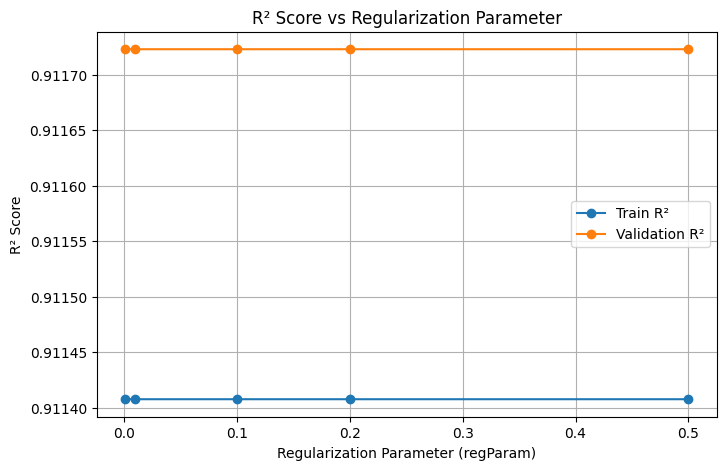

In [14]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Evaluator for R2
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

# Regularization parameters to test
reg_list = [0.5, 0.2, 0.1, 0.01, 0.001]

# Lists to store R2 scores
train_r2_list = []
val_r2_list = []

for reg in reg_list:
    lr = LinearRegression(featuresCol='features', labelCol='price', regParam=reg)
    lr_model = lr.fit(train_data)

    # Predictions
    train_predictions = lr_model.transform(train_data)
    val_predictions = lr_model.transform(val_data)

    # Evaluate R2
    train_r2 = evaluator.evaluate(train_predictions)
    val_r2 = evaluator.evaluate(val_predictions)

    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(reg_list, train_r2_list, marker='o', label='Train R²')
plt.plot(reg_list, val_r2_list, marker='o', label='Validation R²')
# plt.xscale('log')  # because regParam is usually tested on a log scale
plt.xlabel('Regularization Parameter (regParam)')
plt.ylabel('R² Score')
plt.title('R² Score vs Regularization Parameter')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='price', regParam=0.1)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

## Random forest

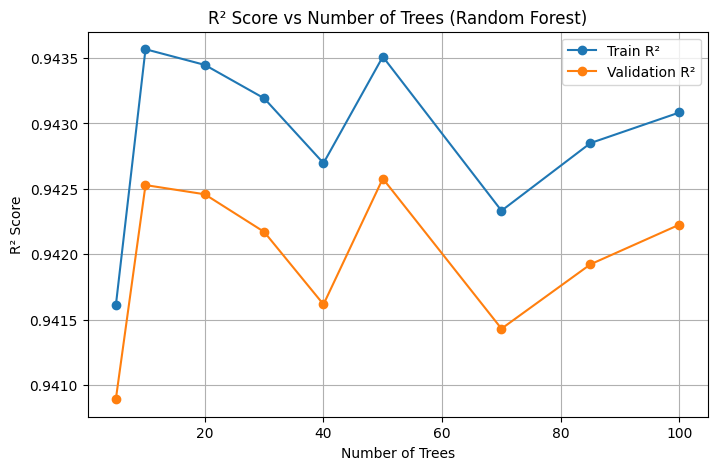

In [18]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

# Hyperparameter list
tree_list = [5, 10, 20,30,40, 50,70,85,100]

# Store results
train_r2_list = []
val_r2_list = []

for num_trees in tree_list:
    rf = RandomForestRegressor(featuresCol='features', labelCol='price', numTrees=num_trees)
    rf_model = rf.fit(train_data)

    # Predictions
    train_pred = rf_model.transform(train_data)
    val_pred = rf_model.transform(val_data)

    # R² scores
    train_r2 = evaluator.evaluate(train_pred)
    val_r2 = evaluator.evaluate(val_pred)

    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tree_list, train_r2_list, marker='o', label='Train R²')
plt.plot(tree_list, val_r2_list, marker='o', label='Validation R²')
plt.xlabel('Number of Trees')
plt.ylabel('R² Score')
plt.title('R² Score vs Number of Trees (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


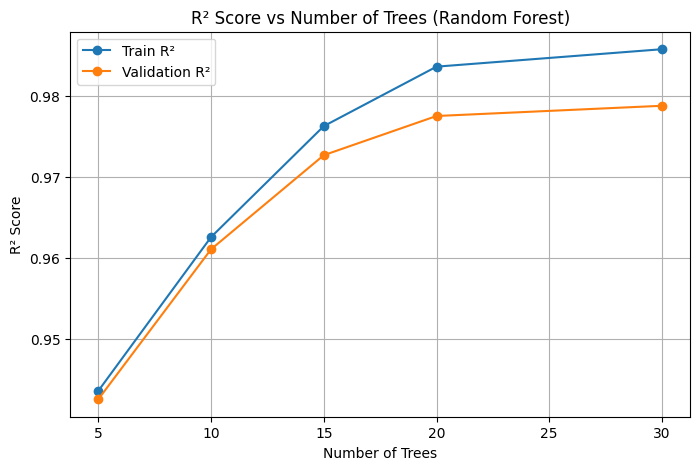

In [26]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

# Hyperparameter list
depthes_list = [5, 10, 15, 20, 30]

# Store results
train_r2_list = []
val_r2_list = []

for max_depth in depthes_list:
    rf = RandomForestRegressor(featuresCol='features', labelCol='price', numTrees=10, maxDepth=max_depth)
    rf_model = rf.fit(train_data)

    # Predictions
    train_pred = rf_model.transform(train_data)
    val_pred = rf_model.transform(val_data)

    # R² scores
    train_r2 = evaluator.evaluate(train_pred)
    val_r2 = evaluator.evaluate(val_pred)

    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(depthes_list, train_r2_list, marker='o', label='Train R²')
plt.plot(depthes_list, val_r2_list, marker='o', label='Validation R²')
plt.xlabel('Number of Trees')
plt.ylabel('R² Score')
plt.title('R² Score vs Number of Trees (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='price', numTrees=10, maxDepth=20)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

##Gradient boosted tree

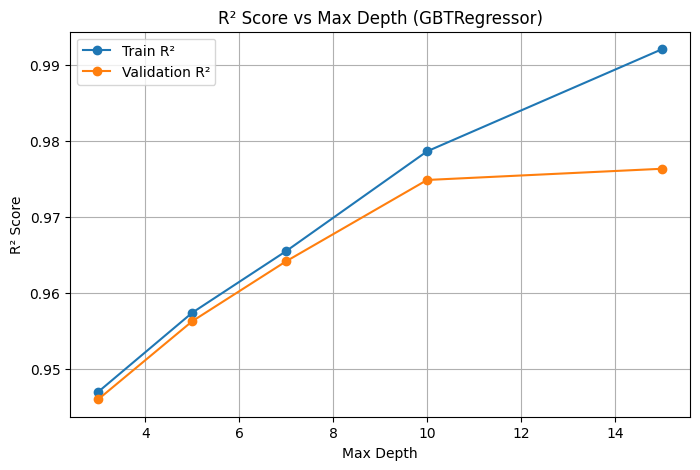

In [9]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

depthes_list = [3,5,7,10,15]

# Store results
train_r2_list = []
val_r2_list = []

for max_depth in depthes_list:
    gbt = GBTRegressor(featuresCol='features',labelCol='price',maxDepth=max_depth, stepSize=0.1)
    gbt_model = gbt.fit(train_data)

    # Predictions
    train_pred = gbt_model.transform(train_data)
    val_pred = gbt_model.transform(val_data)

    # R² scores
    train_r2 = evaluator.evaluate(train_pred)
    val_r2 = evaluator.evaluate(val_pred)

    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(depthes_list, train_r2_list, marker='o', label='Train R²')
plt.plot(depthes_list, val_r2_list, marker='o', label='Validation R²')
plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('R² Score vs Max Depth (GBTRegressor)')
plt.legend()
plt.grid(True)
plt.show()


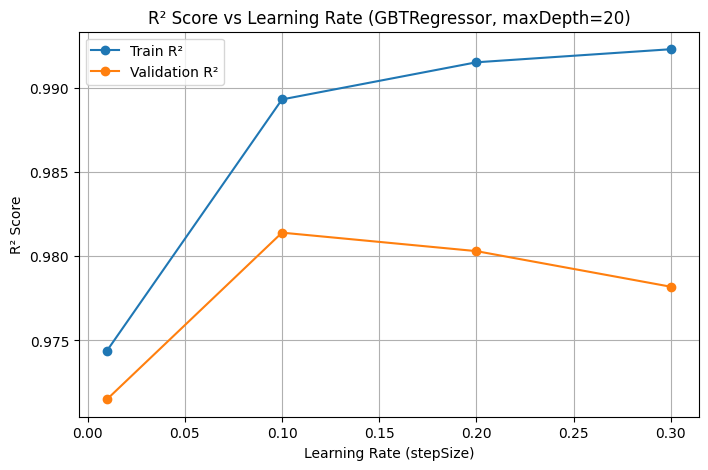

In [10]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

# Learning rates to try
learning_rates = [0.01, 0.1, 0.2, 0.3]

# Store results
train_r2_list = []
val_r2_list = []

for lr in learning_rates:
    gbt = GBTRegressor(featuresCol='features',labelCol='price',maxDepth=10,stepSize=lr,maxIter=100)
    gbt_model = gbt.fit(train_data)

    # Predictions
    train_pred = gbt_model.transform(train_data)
    val_pred = gbt_model.transform(val_data)

    # R² scores
    train_r2 = evaluator.evaluate(train_pred)
    val_r2 = evaluator.evaluate(val_pred)

    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, train_r2_list, marker='o', label='Train R²')
plt.plot(learning_rates, val_r2_list, marker='o', label='Validation R²')
plt.xlabel('Learning Rate (stepSize)')
plt.ylabel('R² Score')
plt.title('R² Score vs Learning Rate (GBTRegressor, maxDepth=20)')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
gbt = GBTRegressor(featuresCol='features',labelCol='price',maxDepth=10, stepSize=0.1)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

## Evaluate model prediction performance

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
# R² (Coefficient of Determination) (the more close to 1 the better)
evaluator_r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2_rf = evaluator_r2.evaluate(rf_predictions)
r2_lr = evaluator_r2.evaluate(lr_predictions)
r2_gbt = evaluator_r2.evaluate(gbt_predictions)
print(f"Random Forest R²: {r2_rf}")
print(f"Linear Regression R²: {r2_lr}")
print(f"Gradient-Boosted Tree R²: {r2_gbt}")
print('\n')

# RMSE (Root Mean Squared Error) (Lower is better)
evaluator_rmse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator_rmse.evaluate(rf_predictions)
rmse_lr = evaluator_rmse.evaluate(lr_predictions)
rmse_gbt = evaluator_rmse.evaluate(gbt_predictions)
print(f"Random Forest RMSE: {rmse_rf}")
print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Gradient-Boosted Tree RMSE: {rmse_gbt}")
print('\n')
# MAE (Mean Absolute Error) (Lowers better)
evaluator_mae = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
mae_rf = evaluator_mae.evaluate(rf_predictions)
mae_lr = evaluator_mae.evaluate(lr_predictions)
mae_gbt = evaluator_mae.evaluate(gbt_predictions)
print(f"Random Forest MAE: {mae_rf}")
print(f"Linear Regression MAE: {mae_lr}")
print(f"Gradient-Boosted Tree MAE: {mae_gbt}")



Random Forest R²: 0.9397053706529719
Linear Regression R²: 0.911304865209225
Gradient-Boosted Tree R²: 0.9662048496417468


Random Forest RMSE: 5575.016826862358
Linear Regression RMSE: 6761.713520731718
Gradient-Boosted Tree RMSE: 4173.823300317609


Random Forest MAE: 3314.9248350960997
Linear Regression MAE: 4553.287802116831
Gradient-Boosted Tree MAE: 2391.792280592565


In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
# R² (Coefficient of Determination) (the more close to 1 the better)
evaluator_r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2_rf = evaluator_r2.evaluate(rf_predictions)
r2_lr = evaluator_r2.evaluate(lr_predictions)
r2_gbt = evaluator_r2.evaluate(gbt_predictions)
print(f"Random Forest R²: {r2_rf}")
print(f"Linear Regression R²: {r2_lr}")
print(f"Gradient-Boosted Tree R²: {r2_gbt}")
print('\n')

# RMSE (Root Mean Squared Error) (Lower is better)
evaluator_rmse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator_rmse.evaluate(rf_predictions)
rmse_lr = evaluator_rmse.evaluate(lr_predictions)
rmse_gbt = evaluator_rmse.evaluate(gbt_predictions)
print(f"Random Forest RMSE: {rmse_rf}")
print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Gradient-Boosted Tree RMSE: {rmse_gbt}")
print('\n')
# MAE (Mean Absolute Error) (Lowers better)
evaluator_mae = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
mae_rf = evaluator_mae.evaluate(rf_predictions)
mae_lr = evaluator_mae.evaluate(lr_predictions)
mae_gbt = evaluator_mae.evaluate(gbt_predictions)
print(f"Random Forest MAE: {mae_rf}")
print(f"Linear Regression MAE: {mae_lr}")
print(f"Gradient-Boosted Tree MAE: {mae_gbt}")



Random Forest R²: 0.9783722075805755
Linear Regression R²: 0.9113014393822189
Gradient-Boosted Tree R²: 0.9748337083536095


Random Forest RMSE: 3338.973436348439
Linear Regression RMSE: 6761.84410420265
Gradient-Boosted Tree RMSE: 3601.7741788150265


Random Forest MAE: 1669.4653409596233
Linear Regression MAE: 4555.572743967151
Gradient-Boosted Tree MAE: 1974.2588758011325


# testing a new point

In [21]:
new_sample_dict = {
    'duration': 10,
    'days_left': 1,

    # Airline
    'airline_AirAsia': 0,
    'airline_Air_India': 0,
    'airline_GO_FIRST': 0,
    'airline_Indigo': 1,
    'airline_SpiceJet': 0,
    'airline_Vistara': 0,

    # Source City
    'source_city_Bangalore': 0,
    'source_city_Chennai': 0,
    'source_city_Delhi': 1,
    'source_city_Hyderabad': 0,
    'source_city_Kolkata': 0,
    'source_city_Mumbai': 0,

    # Departure Time
    'departure_time_Afternoon': 0,
    'departure_time_Early_Morning': 0,
    'departure_time_Evening': 0,
    'departure_time_Late_Night': 0,
    'departure_time_Morning': 0,
    'departure_time_Night': 1,

    # Stops
    'stops_one': 0,
    'stops_two_or_more': 1,
    'stops_zero': 0,

    # Arrival Time
    'arrival_time_Afternoon': 1,
    'arrival_time_Early_Morning': 0,
    'arrival_time_Evening': 0,
    'arrival_time_Late_Night': 0,
    'arrival_time_Morning': 0,
    'arrival_time_Night': 0,

    # Destination City
    'destination_city_Bangalore': 0,
    'destination_city_Chennai': 0,
    'destination_city_Delhi': 1,
    'destination_city_Hyderabad': 0,
    'destination_city_Kolkata': 0,
    'destination_city_Mumbai': 0,

    # Class
    'class_Business': 1,
    'class_Economy': 0,
}
new_sample_df = pd.DataFrame([new_sample_dict])
new_sample_df[['duration', 'days_left']] = scaler.transform(new_sample_df[['duration', 'days_left']])
spark_new_sample = spark.createDataFrame(new_sample_df)
new_sample_vector = assembler.transform(spark_new_sample).select("features")
prediction = rf_model.transform(new_sample_vector)
prediction.select("features", "prediction").show(truncate=False)

+-----------------------------------------------------------------------------+-----------------+
|features                                                                     |prediction       |
+-----------------------------------------------------------------------------+-----------------+
|(37,[0,5,10,19,21,23,31,35],[0.1871428571428571,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|62976.13333333334|
+-----------------------------------------------------------------------------+-----------------+



##Exploratory data analysis (EDA)

In [ ]:
# aggregation of average prices for each factor individually
from pyspark.sql.functions import*

dframe = spark.createDataFrame(df)

price_airline = dframe.select("airline","price")
avg_price_per_airline = price_airline.groupBy("airline").agg(avg("price").alias("avg_price"))
avg_price_per_airline.show()

price_class = dframe.select("class","price")
avg_price_per_class = price_class.groupBy("class").agg(avg("price").alias("avg_price"))
avg_price_per_class.show()

price_dept_time = dframe.select("departure_time","price")
avg_price_per_dept_time = price_dept_time.groupBy("departure_time").agg(avg("price").alias("avg_price"))
avg_price_per_dept_time.show()

price_stops = dframe.select("stops","price")
avg_price_per_stops = price_stops.groupBy("stops").agg(avg("price").alias("avg_price"))
avg_price_per_stops.show()

price_arrival_time = dframe.select("arrival_time","price")
avg_price_per_arrival_time = price_arrival_time.groupBy("arrival_time").agg(avg("price").alias("avg_price"))
avg_price_per_arrival_time.show()

price_source_city = dframe.select("source_city","price")
avg_price_per_source_city = price_source_city.groupBy("source_city").agg(avg("price").alias("avg_price"))
avg_price_per_source_city.show()

price_destination_city = dframe.select("destination_city","price")
avg_price_per_destination_city = price_destination_city.groupBy("destination_city").agg(avg("price").alias("avg_price"))
avg_price_per_destination_city.show()

price_duration = dframe.select("duration","price")
duration_ranges = price_duration.withColumn(
    "duration_bucket",
    when((col("duration") >= 0) & (col("duration") <= 10), "0–10 hrs")
    .when((col("duration") > 10) & (col("duration") <= 20), "11–20 hrs")
    .when((col("duration") > 20) & (col("duration") <= 30), "21–30 hrs")
    .when((col("duration") > 30) & (col("duration") <= 40), "31–40 hrs")
    .when((col("duration") > 40) & (col("duration") <= 50), "41–50 hrs")
    .otherwise("51+ hrs")
)
avg_price_per_duration = duration_ranges.groupBy("duration_bucket").agg(avg("price").alias("avg_price"))
avg_price_per_duration.show()

price_days_left = dframe.select("days_left","price")
avg_price_per_days_left = price_days_left.groupBy("days_left").agg(avg("price").alias("avg_price"))
avg_price_per_days_left.show()


+-------+------------------+
|airline|         avg_price|
+-------+------------------+
|      0|4091.0727419555224|
|      5| 30396.53630170735|
|      1| 23507.01911190229|
|      3| 5324.216303339517|
|      2| 5652.007595045959|
|      4| 6179.278881367218|
+-------+------------------+

+-----+-----------------+
|class|        avg_price|
+-----+-----------------+
|    1|6572.342383362527|
|    0|52540.08112357868|
+-----+-----------------+

+--------------+------------------+
|departure_time|         avg_price|
+--------------+------------------+
|             0|18179.203330962046|
|             5|23062.146808289075|
|             1| 20370.67671807157|
|             3| 9295.299387442572|
|             2| 21232.36189364382|
|             4|21630.760253563094|
+--------------+------------------+

+-----+------------------+
|stops|         avg_price|
+-----+------------------+
|    0|  22900.9924819523|
|    1|14113.450775252146|
|    2| 9375.938534607265|
+-----+------------------+

+

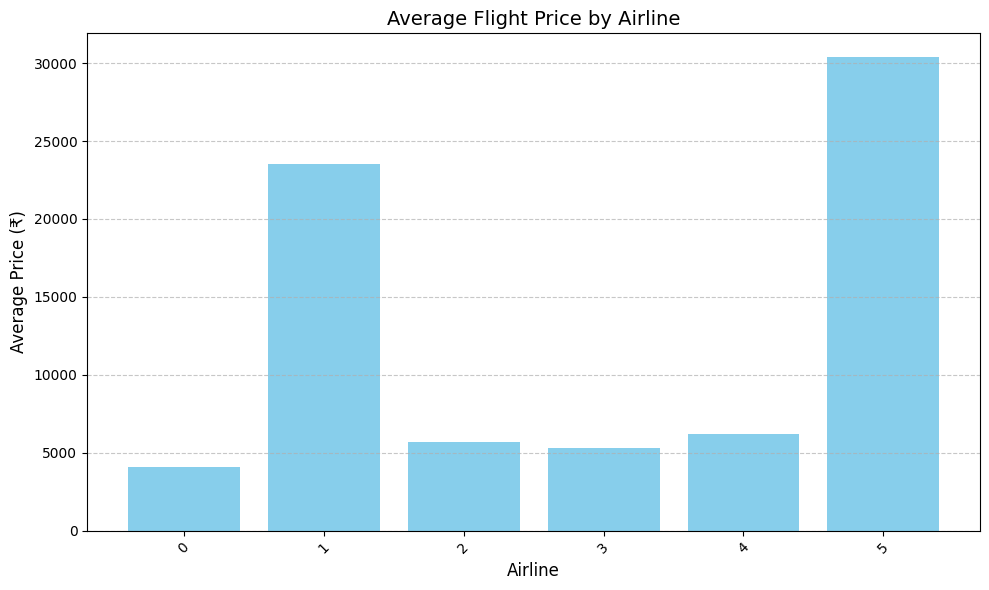

In [ ]:
# plots of the previous relationships

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

########################################boxplot(shaklo qazer)#########################################
#avg_price_pd = price_airline.toPandas()
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=avg_price_pd, x='airline', y='price', showfliers=False, palette='pastel')

# plt.title('Flight Price Distribution by Airline', fontsize=14)
# plt.xlabel('Airline', fontsize=12)
# plt.ylabel('Price (₹)', fontsize=12)
# plt.xticks(rotation=30)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

#########################################barchart############################################
avg_price_pd = avg_price_per_airline.toPandas().sort_values(by='avg_price', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(avg_price_pd['airline'], avg_price_pd['avg_price'], color='skyblue')

plt.title('Average Flight Price by Airline', fontsize=14)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-62-fa241c14bfb2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_per_class_pd, x='class', y='avg_price', palette='coolwarm')


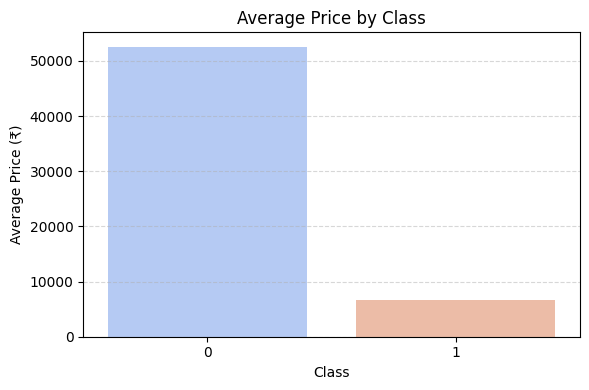

In [ ]:
avg_price_per_class_pd = avg_price_per_class.toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(data=avg_price_per_class_pd, x='class', y='avg_price', palette='coolwarm')
plt.title('Average Price by Class')
plt.xlabel('Class')
plt.ylabel('Average Price (₹)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-63-d9ac6b0eb2b6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_per_dept_time_pd, x='departure_time', y='avg_price', palette='crest')


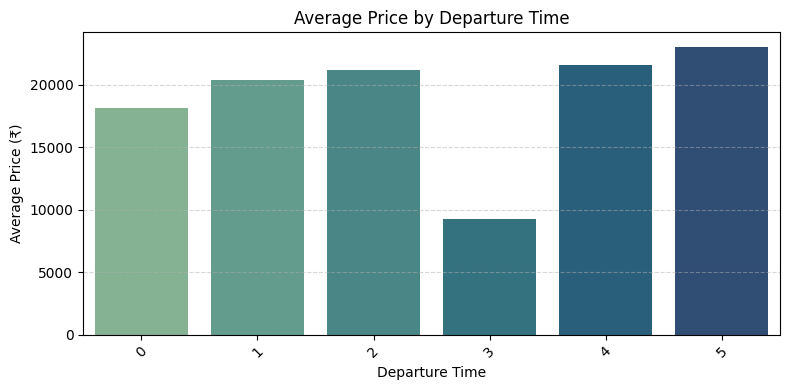

In [ ]:
avg_price_per_dept_time_pd = avg_price_per_dept_time.toPandas()

plt.figure(figsize=(8, 4))
sns.barplot(data=avg_price_per_dept_time_pd, x='departure_time', y='avg_price', palette='crest')
plt.title('Average Price by Departure Time')
plt.xlabel('Departure Time')
plt.ylabel('Average Price (₹)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-64-8bc7bafc8547>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_per_stops_pd, x='stops', y='avg_price', palette='light:#5A9')


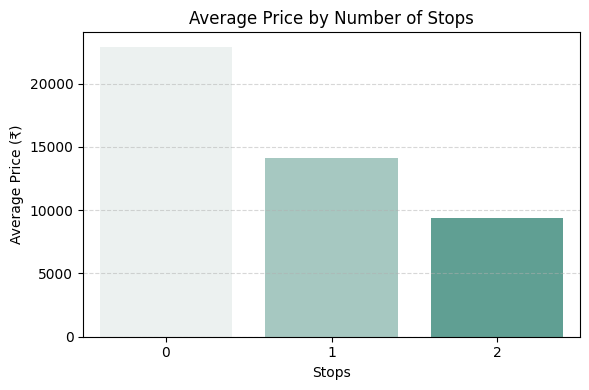

In [ ]:
avg_price_per_stops_pd = avg_price_per_stops.toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(data=avg_price_per_stops_pd, x='stops', y='avg_price', palette='light:#5A9')
plt.title('Average Price by Number of Stops')
plt.xlabel('Stops')
plt.ylabel('Average Price (₹)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-65-4d85acfca179>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_per_arrival_time_pd, x='arrival_time', y='avg_price', palette='mako')


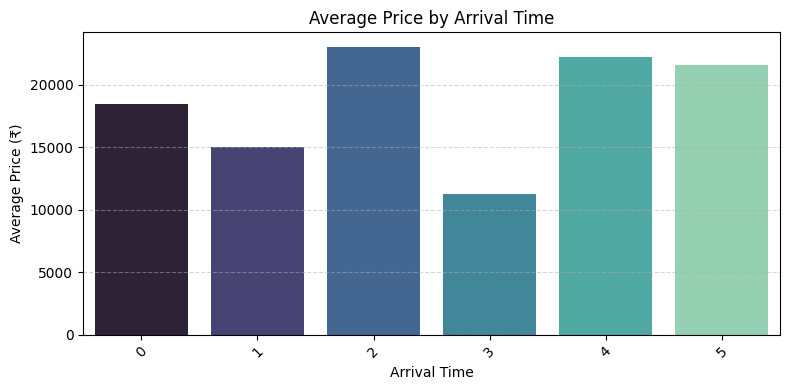

In [ ]:
avg_price_per_arrival_time_pd = avg_price_per_arrival_time.toPandas()

plt.figure(figsize=(8, 4))
sns.barplot(data=avg_price_per_arrival_time_pd, x='arrival_time', y='avg_price', palette='mako')
plt.title('Average Price by Arrival Time')
plt.xlabel('Arrival Time')
plt.ylabel('Average Price (₹)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-66-094faa0d426c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_per_source_city_pd, x='source_city', y='avg_price', palette='flare')


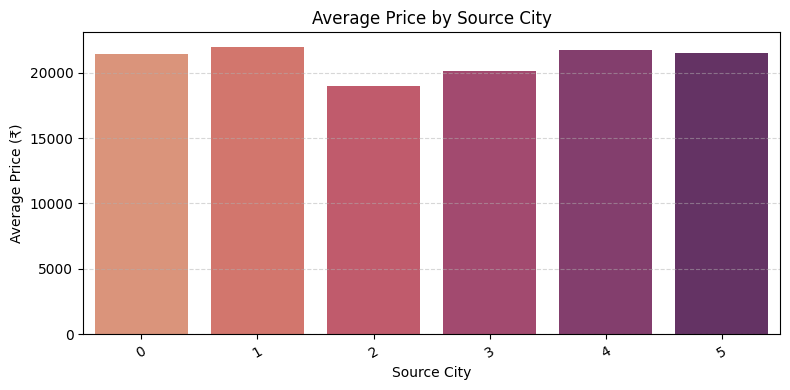

In [ ]:
avg_price_per_source_city_pd = avg_price_per_source_city.toPandas()

plt.figure(figsize=(8, 4))
sns.barplot(data=avg_price_per_source_city_pd, x='source_city', y='avg_price', palette='flare')
plt.title('Average Price by Source City')
plt.xlabel('Source City')
plt.ylabel('Average Price (₹)')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-67-e232cd39d8e2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_per_destination_city_pd, x='destination_city', y='avg_price', palette='rocket')


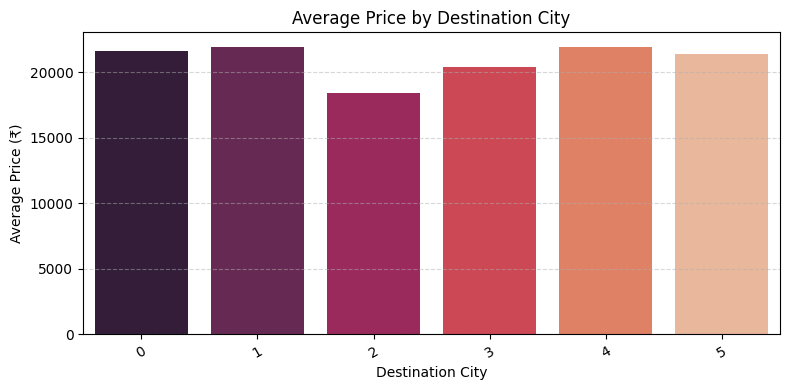

In [ ]:
avg_price_per_destination_city_pd = avg_price_per_destination_city.toPandas()

plt.figure(figsize=(8, 4))
sns.barplot(data=avg_price_per_destination_city_pd, x='destination_city', y='avg_price', palette='rocket')
plt.title('Average Price by Destination City')
plt.xlabel('Destination City')
plt.ylabel('Average Price (₹)')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-71-a44dee32a009>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_per_duration_pd.sort_values("avg_price"), x='duration_bucket', y='avg_price', palette='Spectral')


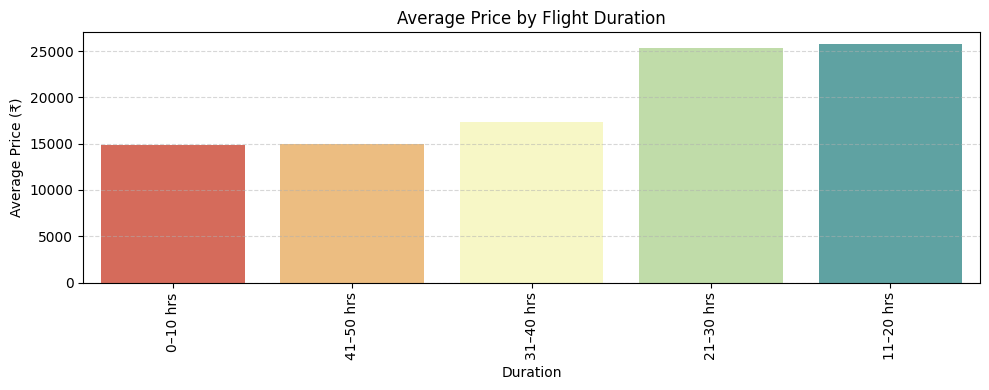

In [ ]:
avg_price_per_duration_pd = avg_price_per_duration.toPandas()

plt.figure(figsize=(10, 4))
sns.barplot(data=avg_price_per_duration_pd.sort_values("avg_price"), x='duration_bucket', y='avg_price', palette='Spectral')
plt.title('Average Price by Flight Duration')
plt.xlabel('Duration')
plt.ylabel('Average Price (₹)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


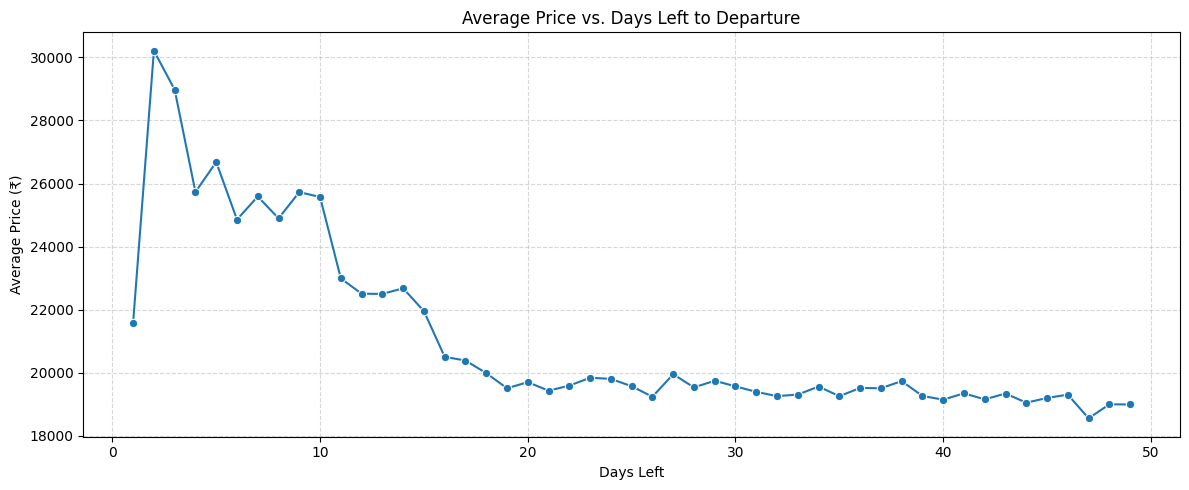

In [ ]:
avg_price_per_days_left_pd = avg_price_per_days_left.toPandas()

plt.figure(figsize=(12, 5))
sns.lineplot(data=avg_price_per_days_left_pd.sort_values("days_left"), x='days_left', y='avg_price', marker='o')
plt.title('Average Price vs. Days Left to Departure')
plt.xlabel('Days Left')
plt.ylabel('Average Price (₹)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# aggreagting prices with more than 1 factor at a time

# route(source,destination) and stops
source_destination = dframe.select("source_city","destination_city","stops","price")
routes = source_destination.groupBy("source_city", "destination_city","stops").agg(avg("price").alias("average_price"),count("*").alias("route_count"))
routes.show()

# to 5 most expensive routes
expensive_routes = source_destination.groupBy("source_city", "destination_city").agg(avg("price").alias("avg_price")).orderBy(desc("avg_price")).limit(5)
expensive_routes.show()

# airline and class
airline_class = dframe.select("airline","class","price")
airline_class_seats = airline_class.groupBy("airline","class").agg(avg("price").alias("average_price"),count("*").alias("seats_count"))
airline_class_seats.show()

# airline , destination and stops
airline_dest_stops = dframe.select("airline","destination_city","stops","price")
airline_dest_stops_avg_price = airline_dest_stops.groupBy("airline","destination_city","stops").agg(avg("price").alias("average_price"))
airline_dest_stops_avg_price.show()


+-----------+----------------+-----+------------------+-----------+
|source_city|destination_city|stops|     average_price|route_count|
+-----------+----------------+-----+------------------+-----------+
|          0|               5|    0|  25806.2156133829|      11029|
|          0|               3|    2|3041.7625570776254|        876|
|          5|               2|    1| 7195.815384615385|         65|
|          4|               3|    2|  6135.81978021978|        455|
|          0|               2|    2|13215.595205789235|       2211|
|          2|               3|    0| 18840.40637966805|       7712|
|          5|               1|    2| 8975.697802197803|       1092|
|          4|               3|    0|23463.665748659227|       6899|
|          4|               2|    2|11354.091925465838|       1610|
|          4|               5|    2|10973.624338624339|        945|
|          2|               1|    0|20273.372308432576|       8313|
|          2|               5|    2|11136.777284

<ipython-input-76-6d3b7cd05501>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_pd, x='route', y='avg_price', palette='Spectral')


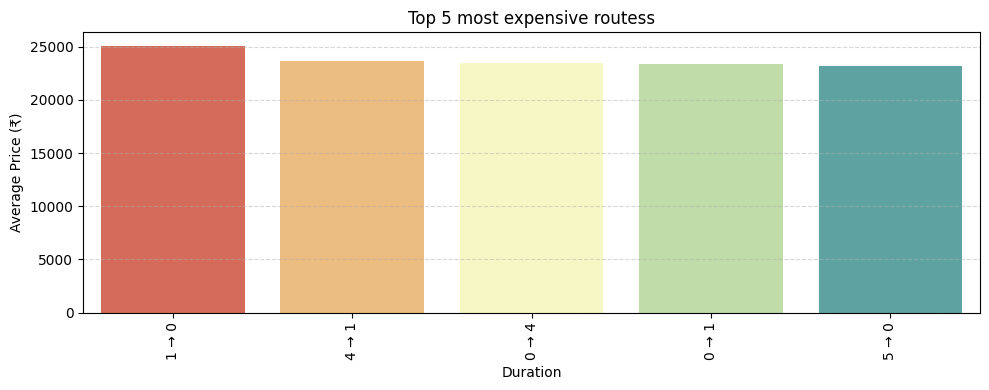

In [ ]:
top5_pd = expensive_routes.toPandas()
top5_pd["route"] = top5_pd["source_city"].astype(str) + " → " + top5_pd["destination_city"].astype(str)

plt.figure(figsize=(10, 4))
sns.barplot(data=top5_pd, x='route', y='avg_price', palette='Spectral')
plt.title('Top 5 most expensive routess')
plt.xlabel('Duration')
plt.ylabel('Average Price (₹)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


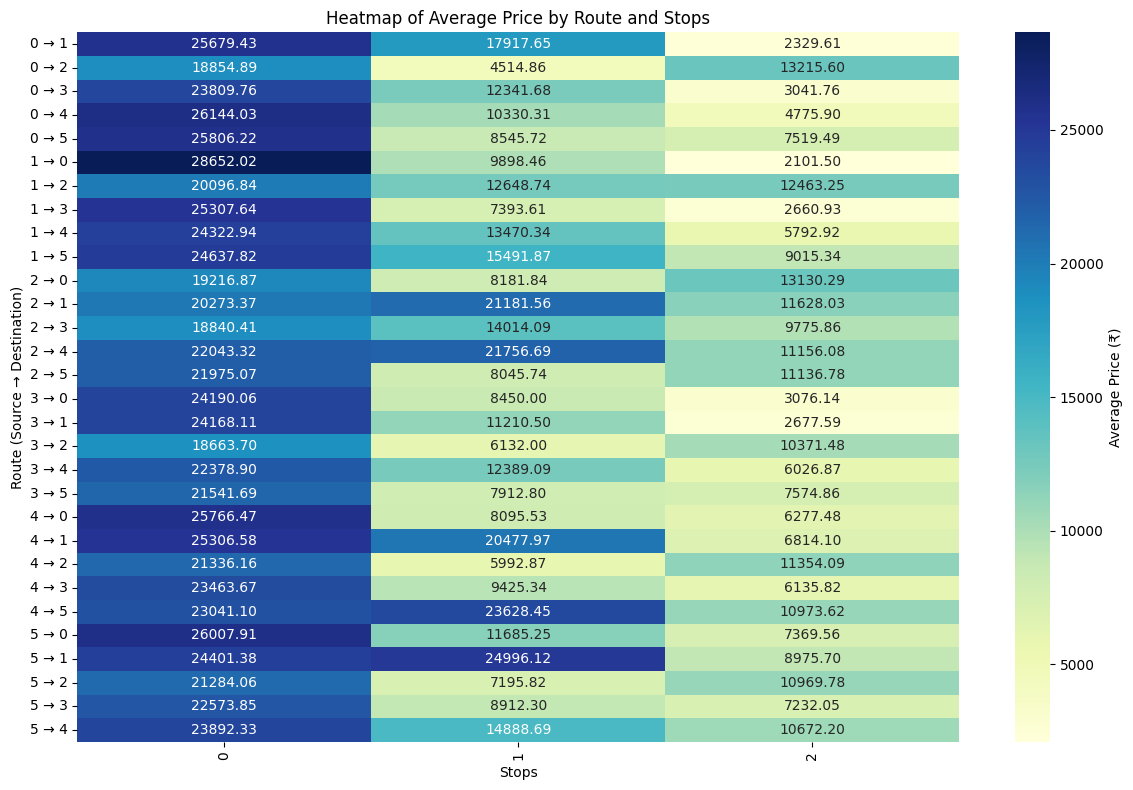

In [ ]:
routes_pd = routes.toPandas()

routes_pd["route"] = routes_pd["source_city"].astype(str) + " → " + routes_pd["destination_city"].astype(str)

# Pivot the data to create a matrix with 'route' as index, 'stops' as columns, and 'average_price' as values
heatmap_data = routes_pd.pivot_table(index="route",
                                    columns="stops",
                                    values="average_price",
                                    aggfunc="mean")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Price (₹)'})
plt.title('Heatmap of Average Price by Route and Stops')
plt.xlabel('Stops')
plt.ylabel('Route (Source → Destination)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

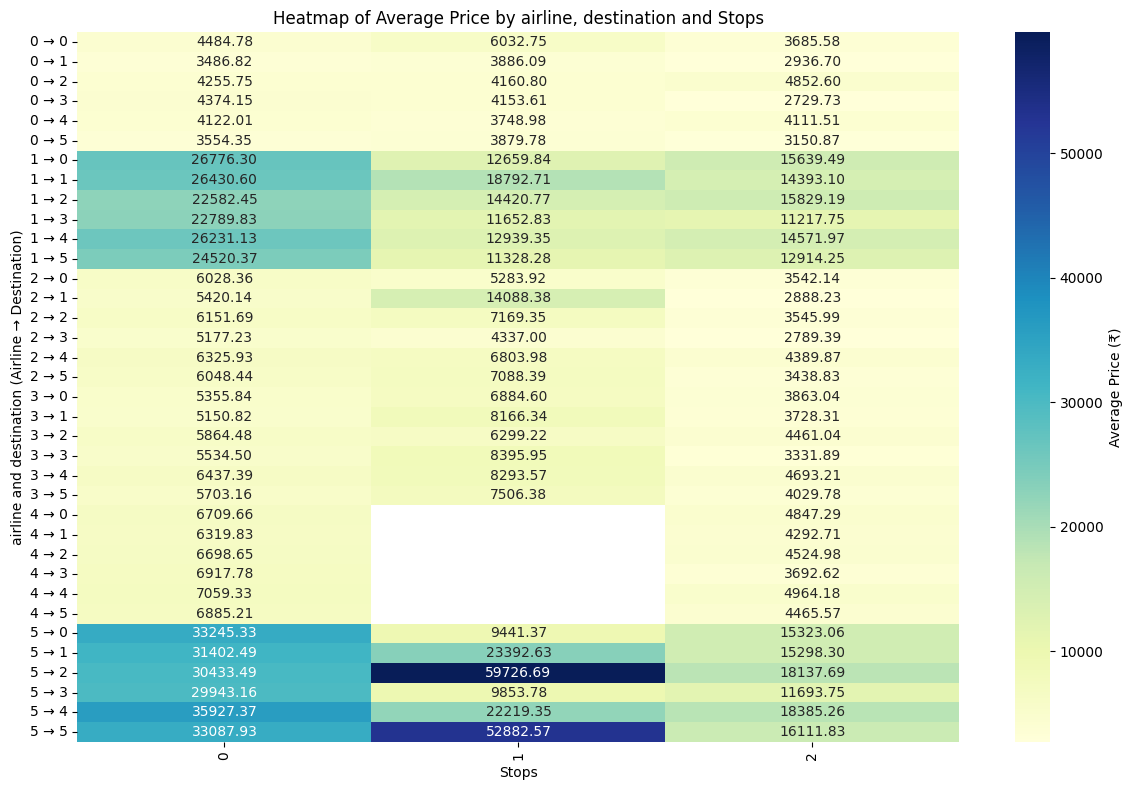

In [ ]:
airline_dest_stops_avg_price_pd = airline_dest_stops_avg_price.toPandas()

airline_dest_stops_avg_price_pd["route"] = airline_dest_stops_avg_price_pd["airline"].astype(str) + " → " + airline_dest_stops_avg_price_pd["destination_city"].astype(str)


heatmap_data = airline_dest_stops_avg_price_pd.pivot_table(index="route",
                                    columns="stops",
                                    values="average_price",
                                    aggfunc="mean")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Price (₹)'})
plt.title('Heatmap of Average Price by airline, destination and Stops')
plt.xlabel('Stops')
plt.ylabel('airline and destination (Airline → Destination)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

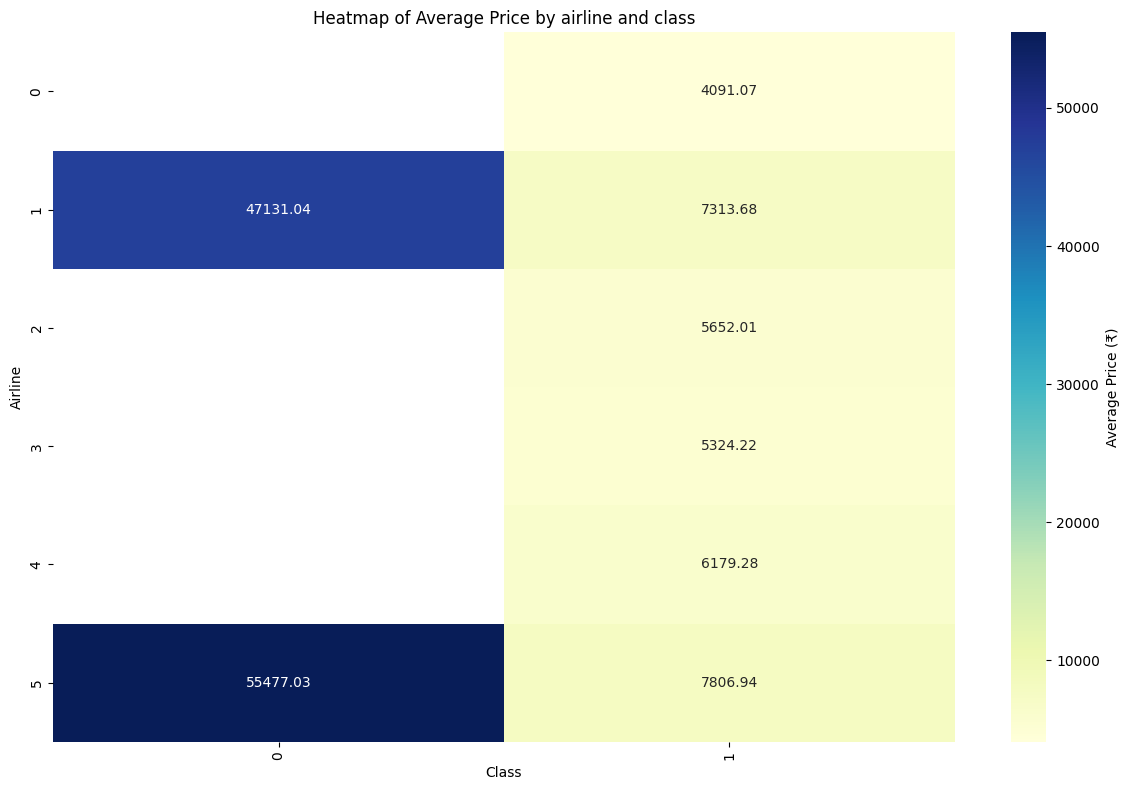

In [ ]:


airline_class_seats_pd = airline_class_seats.toPandas()

heatmap_data = airline_class_seats_pd.pivot_table(index="airline",
                                    columns="class",
                                    values="average_price",
                                    aggfunc="mean")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Price (₹)'})
plt.title('Heatmap of Average Price by airline and class')
plt.xlabel('Class')
plt.ylabel('Airline')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()